In [ ]:
import numpy as np
import torch as pt
from torchvision.utils import save_image
import time
import tqdm
from torchvision.transforms import GaussianBlur

data = np.load('./depth_grid.npy', allow_pickle=True)
grid = pt.tensor(data.item().get('depth_grid'))
ray = pt.tensor(data.item().get('light_direction')).view(3)
orig = pt.clone(grid[:, :, 2])


In [ ]:
blurred_orig = GaussianBlur(kernel_size=13, sigma=2.0)(orig.unsqueeze(0).unsqueeze(0))

mask = orig != 0
mask = mask.float().unsqueeze(0).unsqueeze(0)
blurred_mask = GaussianBlur(kernel_size=13, sigma=2.0)(mask)
blurred_mask[blurred_mask == 0] = 1e-10
blurred_orig = blurred_orig / blurred_mask
# Remove batch and channel dimensions
blurred_orig = blurred_orig.squeeze(0).squeeze(0)

blur_mask = (orig == 0).float()
blurred_orig = blurred_orig * (1 - blur_mask)

grid[:, :, 2] = blurred_orig

# apply gaussian blur to orig
# save_image(blurred_orig, "orig_blur.png")
# exit()

grid[:, :, 2] *= 100
# print(grid.shape, pt.std(grid, dim=(0, 1)))
# exit()

for b in range(100):
  # b = 20
  vis = pt.clone(orig)
  print(b)
  ray[0] = np.sin(b / 100 * np.pi * 2)
  ray[1] = np.cos(b / 100 * np.pi * 2)
  ray[2] = 0.5

  ray = ray / pt.norm(ray)

  orth = pt.cross(ray, pt.tensor([0, 0, 1.0], dtype=pt.double))
  orth2 = pt.cross(ray, orth)
  orth = orth / pt.norm(orth)
  orth2 = orth2 / pt.norm(orth2)
#
  max_radius = 0.2

  big_coords = []
  round = 30
  for ti in range(round):
    tt = ti / (round - 1) * 2 * np.pi * 3

    n = 224
    pray = (orth * np.cos(tt) + orth2 * np.sin(tt)) * (ti / (round - 1)) * max_radius + ray

    mxaxis = max(abs(pray[0]), abs(pray[1]))
    shift = pray / mxaxis * pt.arange(n).view(n, 1)
    # exit()
    coords = grid.view(1, n, n, 3) + shift.view(n, 1, 1, 3)
    big_coords.append(coords)
  big_coords = pt.cat(big_coords, dim=0)

  output = pt.nn.functional.grid_sample(
    pt.tensor(np.tile(grid[:, :, 2].view(1, 1, n, n), [n * round, 1, 1, 1])),
    big_coords[..., :2] / (n - 1) * 2 - 1,
    align_corners=True)
  diff = big_coords[..., 2] - output[:, 0] 
  # print(diff.shape)
  # print(diff.view(round, -1, n, n).shape)
  # print(pt.min(diff.view(round, -1, n, n), dim=1, keepdim=True)[0].shape)
  kk = pt.mean((pt.min(diff.view(round, -1, n, n), dim=1, keepdim=True)[0] > -0.1) * 1.0, dim=(0, 1)) * 0.5 + 0.5
  vis *= kk 
  # print(kk.shape)
  # exit()
  # vis *= (pt.min(diff, dim=0)[0] > -0.1) * 0.5 + 0.5
  save_image(vis, "output_%03d.png" % b)
  # exit()
  # save_image(vis, "output_vec.png")


In [ ]:
import os
os.system("ffmpeg -y -framerate 30 -i output_%03d.png -c:v libx264 -pix_fmt yuv420p -crf 0 output.mp4")

# Breaking down each part

## Blur mask to prevent the darker from gaussian blur the depth

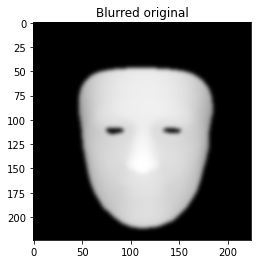

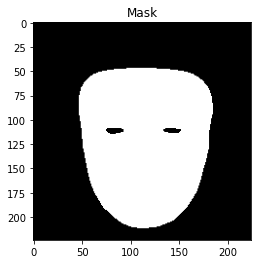

torch.Size([1, 1, 224, 224])


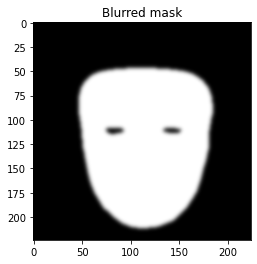

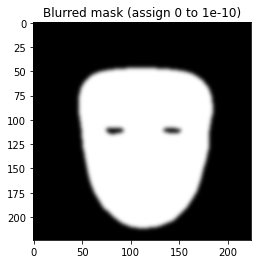

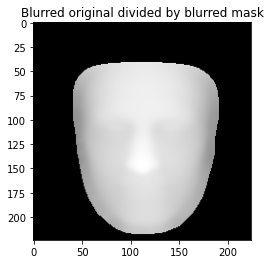

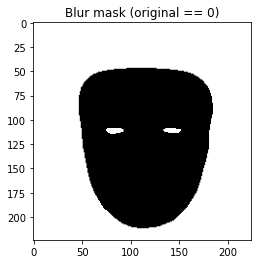

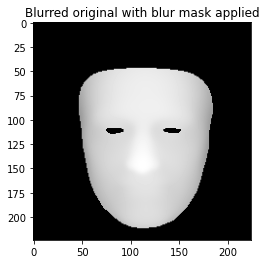

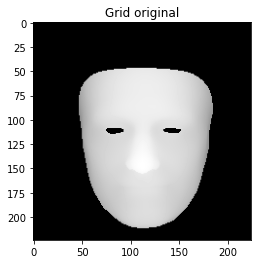

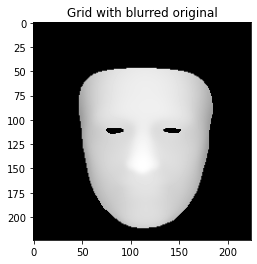

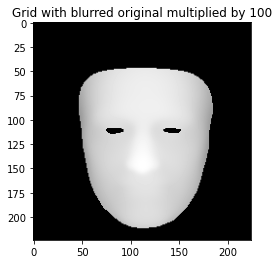

In [7]:
from torchvision.transforms import GaussianBlur
import matplotlib.pyplot as plt

data = np.load('./depth_grid.npy', allow_pickle=True)
grid = pt.tensor(data.item().get('depth_grid'))
ray = pt.tensor(data.item().get('light_direction')).view(3)
orig = pt.clone(grid[:, :, 2])

blurred_orig = GaussianBlur(kernel_size=13, sigma=2.0)(orig.unsqueeze(0).unsqueeze(0))
plt.imshow(blurred_orig.squeeze(0).squeeze(0), cmap='gray')
plt.title('Blurred original')
plt.show()


mask = orig != 0    # mask out the zero values
mask = mask.float().unsqueeze(0).unsqueeze(0)
plt.imshow(mask.squeeze(0).squeeze(0), cmap='gray')
plt.title('Mask')
plt.show()

print(mask.shape)
blurred_mask = GaussianBlur(kernel_size=13, sigma=2.0)(mask)
plt.imshow(blurred_mask.squeeze(0).squeeze(0), cmap='gray')
plt.title('Blurred mask')
plt.show()

blurred_mask[blurred_mask == 0] = 1e-10
plt.imshow(blurred_mask.squeeze(0).squeeze(0), cmap='gray')
plt.title('Blurred mask (assign 0 to 1e-10)')
plt.show()

blurred_orig = blurred_orig / blurred_mask
# Remove batch and channel dimensions
blurred_orig = blurred_orig.squeeze(0).squeeze(0)
plt.imshow(blurred_orig, cmap='gray')
plt.title('Blurred original divided by blurred mask')
plt.show()


# Normal masking
blur_mask = (orig == 0).float()
plt.imshow(blur_mask, cmap='gray')
plt.title('Blur mask (original == 0)')
plt.show()

blurred_orig = blurred_orig * (1 - blur_mask)
plt.imshow(blurred_orig, cmap='gray')
plt.title('Blurred original with blur mask applied')
plt.show()


plt.imshow(grid[:, :, 2], cmap='gray')
plt.title('Grid original')
plt.show()
grid[:, :, 2] = blurred_orig
plt.imshow(grid[:, :, 2], cmap='gray')
plt.title('Grid with blurred original')
plt.show()
grid[:, :, 2] *= 100
plt.imshow(grid[:, :, 2], cmap='gray')
plt.title('Grid with blurred original multiplied by 100')
plt.show()

## Sampling circular around the light direction

In [ ]:
import plotly.graph_objects as go

all_rays = []
all_rays_norm = []
for b in tqdm.tqdm(range(100)):
  # b = 20
  vis = pt.clone(orig)
  ray[0] = np.sin(b / 100 * np.pi * 2)
  ray[1] = np.cos(b / 100 * np.pi * 2)
  ray[2] = 0.5
  ray_norm = ray / pt.norm(ray)
  all_rays.append(ray.clone().numpy())
  all_rays_norm.append(ray_norm.clone().numpy())

# Plot the all rays in 3D
fig = go.Figure()
for i, ray_i in enumerate(all_rays):
  fig.add_trace(go.Scatter3d(x=[0, ray_i[0]], y=[0, ray_i[1]], z=[0, ray_i[2]], mode='lines', name=f'ray_{i}'))
fig.show()

# fig = go.Figure()
# for i, ray_i in enumerate(all_rays_norm):
#   fig.add_trace(go.Scatter3d(x=[0, ray_i[0]], y=[0, ray_i[1]], z=[0, ray_i[2]], mode='lines', name=f'ray_norm_{i}'))
# fig.show()



## Find orthogonal plane on the ray

In [ ]:
import plotly.graph_objects as go

all_rays_norm = []
all_orth_norm = []
all_orth2_norm = []
for b in tqdm.tqdm(range(100)):
    # b = 20
    vis = pt.clone(orig)
    ray[0] = np.sin(b / 100 * np.pi * 2)
    ray[1] = np.cos(b / 100 * np.pi * 2)
    ray[2] = 0.5
    orth = pt.cross(ray, pt.tensor([0, 0, 1.0], dtype=pt.double))  
    orth2 = pt.cross(ray, orth)
    orth = orth / pt.norm(orth)
    orth2 = orth2 / pt.norm(orth2)

    all_rays_norm.append(ray.clone().numpy())
    all_orth_norm.append(orth.clone().numpy())
    all_orth2_norm.append(orth2.clone().numpy())
    # Define the plane that is orthogonal to the ray


# Plot the all rays in 3D
fig = go.Figure()
for i, ray_i in enumerate(all_rays_norm):
    fig.add_trace(go.Scatter3d(x=[0, ray_i[0]], y=[0, ray_i[1]], z=[0, ray_i[2]], mode='lines', name=f'ray_{i}', line=dict(color='red')))
    fig.add_trace(go.Scatter3d(x=[0, all_orth_norm[i][0]], y=[0, all_orth_norm[i][1]], z=[0, all_orth_norm[i][2]], mode='lines', name=f'orth_{i}', line=dict(color='blue')))
    fig.add_trace(go.Scatter3d(x=[0, all_orth2_norm[i][0]], y=[0, all_orth2_norm[i][1]], z=[0, all_orth2_norm[i][2]], mode='lines', name=f'orth2_{i}', line=dict(color='magenta')))
    if i == 50: break
# draw [0, 0, 1] for reference
fig.add_trace(go.Scatter3d(x=[0, 0], y=[0, 0], z=[0, 1], mode='lines', name=f'z-axis', line=dict(color='green')))
fig.show()

## Sampling perturbed ray on plane

In [ ]:
import plotly.graph_objects as go

all_rays_norm = []
all_orth_norm = []
all_orth2_norm = []
all_orth_rot = []
all_orth2_rot = []
all_prays = []
for b in tqdm.tqdm(range(100)):
    # b = 20
    vis = pt.clone(orig)
    ray[0] = np.sin(b / 100 * np.pi * 2)
    ray[1] = np.cos(b / 100 * np.pi * 2)
    ray[2] = 0.5
    orth = pt.cross(ray, pt.tensor([0, 0, 1.0], dtype=pt.double))  
    orth2 = pt.cross(ray, orth)
    orth = orth / pt.norm(orth)
    orth2 = orth2 / pt.norm(orth2)

    all_rays_norm.append(ray.clone().numpy())
    all_orth_norm.append(orth.clone().numpy())
    all_orth2_norm.append(orth2.clone().numpy())
    # Define the plane that is orthogonal to the ray

    max_radius = 0.2

    big_coords = []
    round = 30
    each_pray = []
    for ti in range(round):
        tt = ti / (round - 1) * 2 * np.pi * 3
        # print(tt, ti)
        n = 224
        # orth and orth2 are the two orthogonal vectors to the ray
        # orth * np.cos(tt) oscillates orth along the x axis [-1, 1]
        # orth2 * np.sin(tt) oscillates orth2 along the y axis [-1, 1]
        # combining them orth * np.cos(tt) + orth2 * np.sin(tt) creates a circle
        # (ti / (round - 1)) * max_radius scales the circle
        # ray is the starting point of the circle
        pray = (orth * np.cos(tt) + orth2 * np.sin(tt)) * (ti / (round - 1)) * max_radius + ray
        all_orth_rot.append(orth * np.cos(tt))
        all_orth2_rot.append(orth2 * np.sin(tt))
        each_pray.append(pray.clone().numpy())
    all_prays.append(each_pray)


# Plot the all rays in 3D
fig = go.Figure()
for i, ray_i in enumerate(all_rays_norm):
    fig.add_trace(go.Scatter3d(x=[0, ray_i[0]], y=[0, ray_i[1]], z=[0, ray_i[2]], mode='lines', name=f'ray_{i}', line=dict(color='red')))
    fig.add_trace(go.Scatter3d(x=[0, all_orth_norm[i][0]], y=[0, all_orth_norm[i][1]], z=[0, all_orth_norm[i][2]], mode='lines', name=f'orth_{i}', line=dict(color='blue')))
    fig.add_trace(go.Scatter3d(x=[0, all_orth2_norm[i][0]], y=[0, all_orth2_norm[i][1]], z=[0, all_orth2_norm[i][2]], mode='lines', name=f'orth2_{i}', line=dict(color='magenta')))
    for j, pray in enumerate(all_prays[i]):
        fig.add_trace(go.Scatter3d(x=[0, pray[0]], y=[0, pray[1]], z=[0, pray[2]], mode='lines', name=f'pray_{i}_{j}', line=dict(color='purple')))
        fig.add_trace(go.Scatter3d(x=[0, all_orth_rot[j][0]], y=[0, all_orth_rot[j][1]], z=[0, all_orth_rot[j][2]], mode='lines', name=f'orth_rot_{i}_{j}', line=dict(color='black')))
        fig.add_trace(go.Scatter3d(x=[0, all_orth2_rot[j][0]], y=[0, all_orth2_rot[j][1]], z=[0, all_orth2_rot[j][2]], mode='lines', name=f'orth2_rot_{i}_{j}', line=dict(color='gray')))
    if i == 0: break
# draw [0, 0, 1] for reference
fig.add_trace(go.Scatter3d(x=[0, 0], y=[0, 0], z=[0, 1], mode='lines', name=f'z-axis', line=dict(color='green')))
fig.show()



## Sampling the coords for depth test

In [ ]:
import plotly.graph_objects as go

all_rays_norm = []
all_orth_norm = []
all_orth2_norm = []
all_orth_rot = []
all_orth2_rot = []
all_prays = []
for b in tqdm.tqdm(range(100)):
    # b = 20
    vis = pt.clone(orig)
    ray[0] = np.sin(b / 100 * np.pi * 2)
    ray[1] = np.cos(b / 100 * np.pi * 2)
    ray[2] = 0.5
    orth = pt.cross(ray, pt.tensor([0, 0, 1.0], dtype=pt.double))  
    orth2 = pt.cross(ray, orth)
    orth = orth / pt.norm(orth)
    orth2 = orth2 / pt.norm(orth2)

    all_rays_norm.append(ray.clone().numpy())
    all_orth_norm.append(orth.clone().numpy())
    all_orth2_norm.append(orth2.clone().numpy())
    # Define the plane that is orthogonal to the ray

    max_radius = 0.2

    big_coords = []
    round = 30
    each_pray = []
    for ti in range(round):
        tt = ti / (round - 1) * 2 * np.pi * 3
        n = 224
        pray = (orth * np.cos(tt) + orth2 * np.sin(tt)) * (ti / (round - 1)) * max_radius + ray
        all_orth_rot.append(orth * np.cos(tt))
        all_orth2_rot.append(orth2 * np.sin(tt))
        each_pray.append(pray.clone().numpy())

        mxaxis = max(abs(pray[0]), abs(pray[1]))
        shift = pray / mxaxis * pt.arange(n).view(n, 1)
        coords = grid.view(1, n, n, 3) + shift.view(n, 1, 1, 3)
        big_coords.append(coords)

    big_coords = pt.cat(big_coords, dim=0)
    all_prays.append(each_pray)

    # Plot some of the depth in big_coords [round * n, n, n, 3]
    fig = go.Figure()
    for i in np.linspace(0, (round * n)-1, 5).astype(int):
        fig.add_trace(go.Scatter3d(x=big_coords[i, :, :, 0].view(-1).numpy(), y=big_coords[i, :, :, 1].view(-1).numpy(), z=big_coords[i, :, :, 2].view(-1).numpy(), mode='markers', name=f'ray_{i}', marker=dict(color='red', size=0.25)))
    fig.show()

    assert False


## Adding grid_sample and final output

tensor([[  0.,   1.,   2.,  ..., 221., 222., 223.],
        [  0.,   1.,   2.,  ..., 221., 222., 223.],
        [  0.,   1.,   2.,  ..., 221., 222., 223.],
        ...,
        [  0.,   1.,   2.,  ..., 221., 222., 223.],
        [  0.,   1.,   2.,  ..., 221., 222., 223.],
        [  0.,   1.,   2.,  ..., 221., 222., 223.]], dtype=torch.float64)
tensor([[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  1.,   1.,   1.,  ...,   1.,   1.,   1.],
        [  2.,   2.,   2.,  ...,   2.,   2.,   2.],
        ...,
        [221., 221., 221.,  ..., 221., 221., 221.],
        [222., 222., 222.,  ..., 222., 222., 222.],
        [223., 223., 223.,  ..., 223., 223., 223.]], dtype=torch.float64)
torch.Size([224, 224, 3])


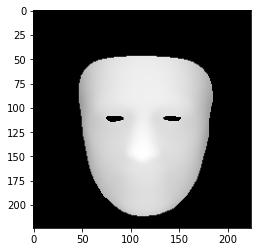

  0%|          | 0/100 [00:00<?, ?it/s]

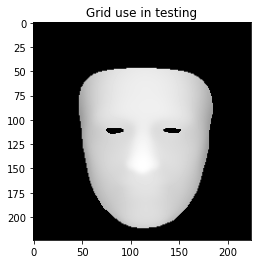

  0%|          | 0/100 [00:01<?, ?it/s]


AssertionError: 

In [6]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import torch as pt
import tqdm
from torchvision.transforms import GaussianBlur

data = np.load('./depth_grid.npy', allow_pickle=True)
grid = pt.tensor(data.item().get('depth_grid'))
ray = pt.tensor(data.item().get('light_direction')).view(3)
orig = pt.clone(grid[:, :, 2])

blurred_orig = GaussianBlur(kernel_size=13, sigma=2.0)(orig.unsqueeze(0).unsqueeze(0))

mask = orig != 0
mask = mask.float().unsqueeze(0).unsqueeze(0)
blurred_mask = GaussianBlur(kernel_size=13, sigma=2.0)(mask)
blurred_mask[blurred_mask == 0] = 1e-10 # prevent division by zero
blurred_orig = blurred_orig / blurred_mask
# Remove batch and channel dimensions
blurred_orig = blurred_orig.squeeze(0).squeeze(0)

blur_mask = (orig == 0).float()
blurred_orig = blurred_orig * (1 - blur_mask)

grid[:, :, 2] = blurred_orig
grid[:, :, 2] *= 100
print(grid[..., 0])
print(grid[..., 1])
print(grid.shape)
plt.imshow(grid[..., 2], cmap='gray')
plt.show()
# assert False

all_rays_norm = []
all_orth_norm = []
all_orth2_norm = []
all_orth_rot = []
all_orth2_rot = []
all_prays = []
# for b in tqdm.tqdm(range(29, 30)):
for b in tqdm.tqdm(range(100)):
    # b = 20
    vis = pt.clone(orig)
    ray[0] = np.sin(b / 100 * np.pi * 2)
    ray[1] = np.cos(b / 100 * np.pi * 2)
    ray[2] = 0.5
    orth = pt.cross(ray, pt.tensor([0, 0, 1.0], dtype=pt.double))  
    orth2 = pt.cross(ray, orth)
    orth = orth / pt.norm(orth)
    orth2 = orth2 / pt.norm(orth2)

    all_rays_norm.append(ray.clone().numpy())
    all_orth_norm.append(orth.clone().numpy())
    all_orth2_norm.append(orth2.clone().numpy())
    # Define the plane that is orthogonal to the ray

    max_radius = 0.2

    big_coords = []
    round = 30
    each_pray = []
    for ti in range(round):
        tt = ti / (round - 1) * 2 * np.pi * 3
        n = 224
        pray = (orth * np.cos(tt) + orth2 * np.sin(tt)) * (ti / (round - 1)) * max_radius + ray
        all_orth_rot.append(orth * np.cos(tt))
        all_orth2_rot.append(orth2 * np.sin(tt))
        each_pray.append(pray.clone().numpy())

        mxaxis = max(abs(pray[0]), abs(pray[1]))
        shift = pray / mxaxis * pt.arange(n).view(n, 1)
        coords = grid.view(1, n, n, 3) + shift.view(n, 1, 1, 3)
        big_coords.append(coords)

    big_coords = pt.cat(big_coords, dim=0)
    all_prays.append(each_pray)

    # Plot some of the depth in big_coords [round * n, n, n, 3]
    plt.imshow(grid[..., 2], cmap='gray')
    plt.title('Grid use in testing')
    plt.show()
    assert False

    output = pt.nn.functional.grid_sample(
    pt.tensor(np.tile(grid[:, :, 2].view(1, 1, n, n), [n * round, 1, 1, 1])),
        big_coords[..., :2] / (n - 1) * 2 - 1,
        align_corners=True)
    diff = big_coords[..., 2] - output[:, 0] 

    # print(pt.max(pt.mean((pt.min(diff.view(round, -1, n, n), dim=1, keepdim=True)[0] > -0.1) * 1.0, dim=(0, 1))))
    # print(pt.min(pt.mean((pt.min(diff.view(round, -1, n, n), dim=1, keepdim=True)[0] > -0.1) * 1.0, dim=(0, 1))))
    # kk = pt.mean((pt.min(diff.view(round, -1, n, n), dim=1, keepdim=True)[0] > -0.1) * 1.0, dim=(0, 1)) * 0.5 + 0.5
    # kk = pt.mean((pt.min(diff.view(round, -1, n, n), dim=1, keepdim=True)[0] > -0.1) * 1.0, dim=(0, 1)) * 0.5 + 0.5
    kk = pt.mean((pt.min(diff.view(round, -1, n, n), dim=1, keepdim=True)[0] > -0.1) * 1.0, dim=(0, 1)) * 1.0
    vis *= kk 

    # print(pt.unique(kk))
    # print(pt.max(vis), pt.min(vis))
    # plt.imshow(np.concatenate((vis, 1-vis), axis=1), cmap='gray')
    # plt.title('vis')
    # plt.show()

    # fig = plt.figure(figsize=(10, 10))
    # plt.imshow(np.concatenate((kk, 1-kk, (1-kk)!=0), axis=1), cmap='gray')
    # plt.title('kk')
    # plt.show()

    plt.imshow(grid[..., 2], cmap='gray')
    plt.show()

    # plt.imshow((vis) == 0, cmap='gray')
    # plt.title('vis == 0')
    # plt.show()

    # plt.imshow((vis) < 0.2, cmap='gray')
    # plt.title('vis < 0.2')
    # plt.show()

    # plt.imshow((vis) < 0.3, cmap='gray')
    # plt.title('vis > 0.3')
    # plt.show()

    # Preprocessing with weight
    # fig = plt.figure(figsize=(10, 10))
    out_vismask = ((1 - vis.clone()) * 0.2) * mask.squeeze(0).squeeze(0) * (((1 - vis.clone()) * 0.2)>0)
    out_kkmask = ((1 - vis.clone()) * 0.2) * mask.squeeze(0).squeeze(0) * ((1-kk) > 0)
    # plt.imshow(np.concatenate((out_vismask, out_kkmask), axis=1), cmap='gray')
    # plt.title('vismask and kkmask')
    # plt.show()

    out_w1 = ((1 - vis.clone()) * 0.14) * mask.squeeze(0).squeeze(0) * ((1-kk) > 0)
    out_w2 = ((1 - vis.clone()) * 0.86) * mask.squeeze(0).squeeze(0) * ((1-kk) > 0)
    # plt.imshow(np.concatenate((out_w1, out_w2), axis=1), cmap='gray')
    # plt.title('w1 and w2')
    # plt.show()
    assert False

    save_image(out_w1, "output_w1_%03d.png" % b)
    save_image(out_w2, "output_w2_%03d.png" % b)
    save_image(vis, "output_vis_%03d.png" % b)
    



In [ ]:
import os
os.system("ffmpeg -y -framerate 30 -i output_%03d.png -c:v libx264 -pix_fmt yuv420p -crf 0 output.mp4")
os.system("ffmpeg -y -framerate 30 -i output_w1_%03d.png -c:v libx264 -pix_fmt yuv420p -crf 0 output_w1.mp4")
os.system("ffmpeg -y -framerate 30 -i output_w2_%03d.png -c:v libx264 -pix_fmt yuv420p -crf 0 output_w2.mp4")
os.system("ffmpeg -y -framerate 30 -i output_vis_%03d.png -c:v libx264 -pix_fmt yuv420p -crf 0 output_vis.mp4")
# concat all videos
os.system("ffmpeg -y -i output.mp4 -i output_vis.mp4 -i output_w1.mp4 -i output_w2.mp4 -filter_complex hstack=inputs=4 output_concat.mp4")